In [89]:
import pandas as pd
pd.set_option('display.max_columns', None)
import missingno as msno
from functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# Data Cleaning pt.1

### Read in the CSV and review matrix

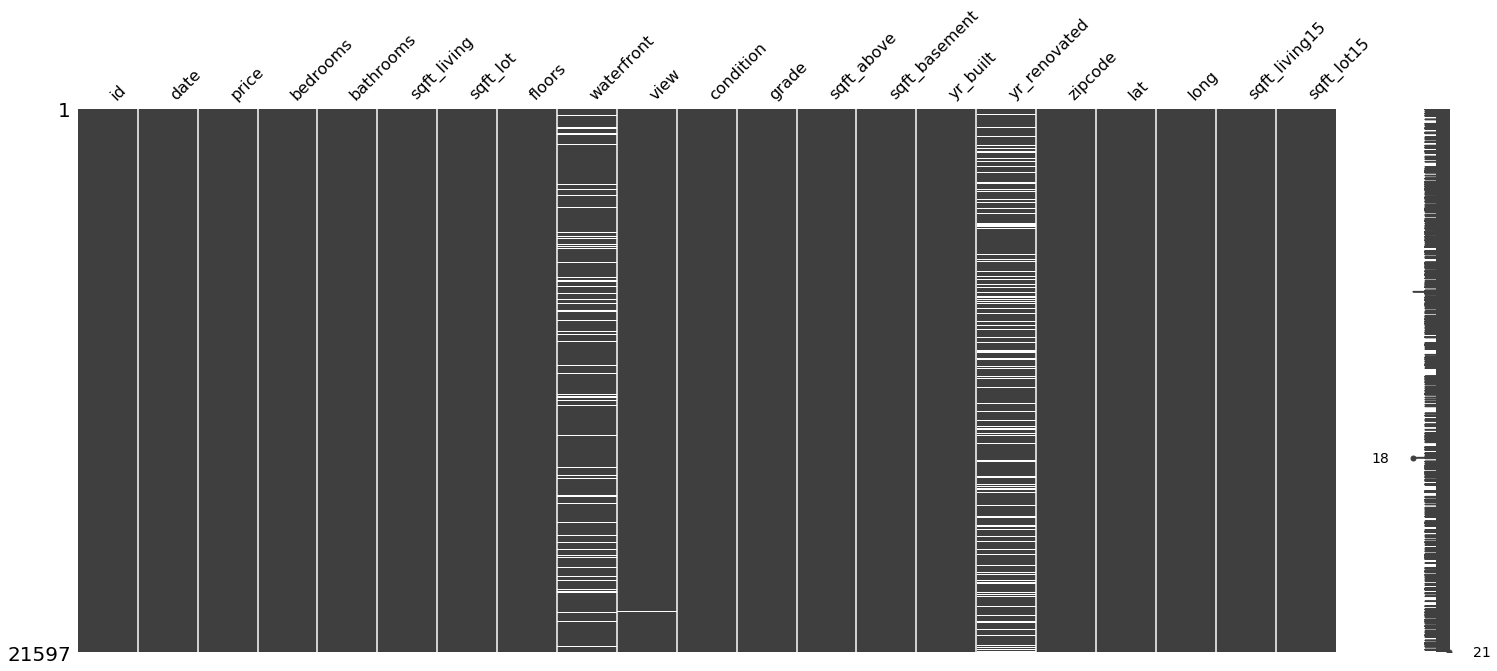

In [90]:
kc_csv = pd.read_csv('./data/kc_house_data.csv')
kcdf = pd.DataFrame(kc_csv)
msno.matrix(kcdf)

In [91]:
# We need to split train test as the very first step before we clean any data. Tests should be unknown at all times. We should use train to calculate mean/median.
# Continue to clean data on training and then apply it to test.

In [92]:
kcdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [93]:
# categorical_columns = ['bathrooms','bedrooms','grade','view','floors']
# # categorical_features = ['bathrooms','bedrooms','grade','view','floors', 'zipcode','yr_built','condition']
# non_categorical_columns = ['id','date','price','sqft_lot','condition','yr_built','zipcode','sqft_living15', 'sqft_lot15']

# # This replaces categorical columns with dummy variables, and drops non categorical columns
# # We have an extra degree of freedom because with dummy columns, we only need one less than listed because a '0' for every column inheritly means its a '1' for the unlisted feature.
# # Look into onehotencoding instead of pd.get_dummies. ISLR - Intro to Stats Learning. Look at Chapter 3

# new_df = pd.DataFrame()

# for feature in categorical_columns:
#     new_df[feature] = kcdf[feature].astype('category')
# new_df.info()


# # importing one hot encoder from sklearn
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# # creating one hot encoder object with categorical feature 0
# # indicating the first column
# le = LabelEncoder()

# kcdf[categorical_columns] = kcdf[categorical_columns].apply(lambda col: le.fit_transform(col))

# # kcdf[categorical_columns].head()

# ohe = OneHotEncoder(categorical_features=categorical_columns, sparse=False)
# kcdf_ohe = ohe.fit_transform(kcdf[categorical_columns])
# kcdf_dict = kcdf[categorical_columns].to_dict(orient='records')
# kcdf_dict


# # kcdf_cat = kcdf.select_dtypes(include=['category'])
# # dummies_array = kcdf_cat.apply(le.fit_transform)

# # enc = OneHotEncoder()

# # # 2. FIT
# # enc.fit(dummies_array.reshape(-1, 1))

# # # 3. Transform
# # onehotlabels = enc.transform(dummies_array).toarray()
# # print(onehotlabels.shape)
# # print(kcdf_cat.shape)

# # dummies_array = onehotlabels
# # dummies_df = pd.DataFrame(dummies_array)
# # dummies_df.head()
# # # (categorical_features = categorcial_columns)
# # # dummies_df = le.fit_transform(kcdf)


# # # dummies_df = pd.get_dummies(cleaned_KC, columns=categorcial_columns).drop(columns=non_categorcial_columns)

In [94]:

categorical_features = ['bathrooms','bedrooms','zipcode','yr_built','grade','condition','view','floors']
for feature in categorical_features:
    kcdf[feature] = kcdf[feature].astype('category')
kcdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null category
bathrooms        21597 non-null category
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null category
waterfront       19221 non-null float64
view             21534 non-null category
condition        21597 non-null category
grade            21597 non-null category
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null category
yr_renovated     17755 non-null float64
zipcode          21597 non-null category
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: category(8), float64(5), int64(6), object(2)
memo

### Replace Values
Based on our EDA, we discovered that the ```sqft_basement``` column had '?' values that we'll need to replace with NAN values and drop those rows.

In [95]:
columns_to_replace = ['sqft_basement']
replace_column_w_nan(kcdf, columns_to_replace, '?')

Replaced ? values from these columns:['sqft_basement']


### Drop Rows
Our matrix shows that the ```view``` column has a view missing values, and our EDA confirms that .29% of values are missing.
Because that is so small, we can drop the NA rows without significantly affecting the data.
We're also dropping the replacement NAN values from the ```sqft_basement``` column.

In [96]:
columns_with_na = ['view', 'sqft_basement','price']
drop_na_rows(kcdf, columns_with_na)

Removed NA rows from these columns:['view', 'sqft_basement', 'price'].


### Drop Columns

The matrix shows significant missing values for the 
```waterfront``` and ```yr_renovated``` columns, and our EDA confirms that 11% and 17.79% (respectively) of the values are missing. 
However, because we wont be using those columns for our analysis, it would be better to preserve the row's data in other columns. We'll choose to drop those columns.

Additionally, we calculated that 
```sqft_above + sqft_basement == sqft_living``` 
so we can drop those columns to reduce noise.

In [97]:
living, basement, above = kcdf.sqft_living.astype(float), kcdf.sqft_basement.astype(float), kcdf.sqft_above.astype(float)
num_of_rows_where_true = (living == basement + above).sum()
num_of_rows_where_true == kcdf.shape[0]

True

On the other hand these columns are relatively equivalent
```lat + long ≈ zipcode```, 
so we can drop those 2 columns to reduce noise as well. 

So we add each column to the list of 'columns_to_drop' and drop those columns.

In [98]:
columns_to_drop = ['waterfront', 'yr_renovated','sqft_above','sqft_basement','lat','long']
drop_columns(kcdf, columns_to_drop)

Dropped these columns:['waterfront', 'yr_renovated', 'sqft_above', 'sqft_basement', 'lat', 'long']


### Extra Checks
In case we need to run any analysis on the string values, we want to sanitize those values by removing all leading/trailing spaces.

In [99]:
strip_spaces(kcdf)

stripped leading/trailing spaces from all cells of string type


### Create X & Y Train/Test variables

In [117]:
categorial_columns = ['bathrooms','bedrooms','grade','view','floors']
non_categorial_columns = ['id','date','sqft_lot','condition','yr_built','zipcode','sqft_living15', 'sqft_lot15']
dummies_df = pd.get_dummies(kcdf, columns=categorial_columns).drop(columns=non_categorial_columns)

In [118]:
# This is 

# This sets X to a dataframe consisting of columns with dummy variables & without extra columns
X = dummies_df.drop(columns=['price'])

# this simply sets y to the price column of the dataframe
y = dummies_df['price']

# This runs a train/test split with .20 of the data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=40)

And we also want to run a quick check for duplicates.

### Review Part 1

Our matrix visually confirms that there are no more missing values in our data.

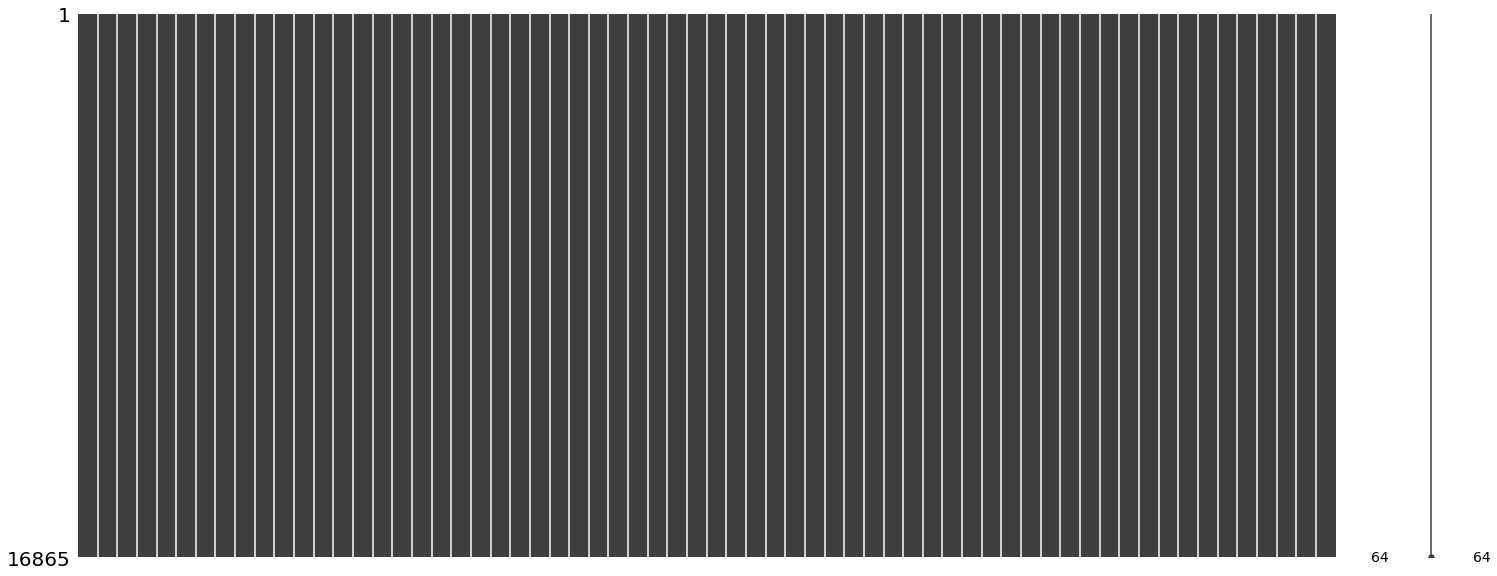

In [119]:
msno.matrix(X_train)

# Data Cleaning pt.2

Now that our data has been sufficiently cleaned of missing values, we can begin to calculate potential outliers.

In [120]:
X_train.describe()

,sqft_living,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,bedrooms_33,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_0.0,view_1.0,view_2.0,view_3.0,view_4.0,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
count,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000,16865.000000
mean,2080.705070,0.000119,0.003380,0.179010,0.000356,0.067003,0.142010,0.089653,0.094337,0.246546,0.054907,0.034509,0.027453,0.035043,0.007234,0.006760,0.003202,0.004625,0.001067,0.000889,0.000593,0.000296,0.000237,0.000296,0.000059,0.000059,0.000119,0.000059,0.000059,0.000119,0.008894,0.126594,0.458464,0.316929,0.074118,0.011800,0.001897,0.000652,0.000356,0.000178,0.000059,0.000059,0.000059,0.001245,0.011088,0.095642,0.414764,0.281530,0.120012,0.052179,0.018381,0.004447,0.000652,0.901927,0.015239,0.043937,0.023718,0.015179,0.495168,0.088704,0.379958,0.007175,0.028758,0.000237
std,920.871572,0.010890,0.058039,0.383372,0.018859,0.250034,0.349071,0.285693,0.292306,0.431013,0.227805,0.182539,0.163405,0.183894,0.084747,0.081941,0.056496,0.067852,0.032653,0.029811,0.024344,0.017216,0.015399,0.017216,0.007700,0.007700,0.010890,0.007700,0.007700,0.010890,0.093891,0.332527,0.498287,0.465293,0.261971,0.107986,0.043519,0.025531,0.018859,0.013336,0.007700,0.007700,0.007700,0.035266,0.104718,0.294108,0.492696,0.449759,0.324985,0.222395,0.134330,0.066540,0.025531,0.297422,0.122504,0.204961,0.152173,0.122270,0.499991,0.284325,0.485391,0.084401,0.167130,0.015399
min,370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1420.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1910.000000,0.000000,0.000000,0.000000,0.000000,0.000000

We determined that the most important ```columns_with_outliers``` to address are ```bathrooms```, ```bedrooms```, ```sqft_living```, and ```price```.

Using interquartile ranges, we will drop all values below the low threshold, and above the high threshold. 

In [121]:
X_train = remove_outliers(X_train,['sqft_living'])

And here we can see that there are no more outliers in any of these columns

In [122]:
X_train.describe()

,sqft_living,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,bedrooms_33,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_0.0,view_1.0,view_2.0,view_3.0,view_4.0,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
count,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.0,16427.000000,16427.0,16427.0,16427.0,16427.0,16427.000000,16427.0,16427.0,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.0,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000,16427.000000
mean,2000.468436,0.000122,0.003470,0.183783,0.000365,0.068789,0.145797,0.091983,0.096427,0.251598,0.055701,0.034334,0.024046,0.030255,0.005722,0.003653,0.000974,0.002313,0.000244,0.000183,0.000122,0.0,0.000061,0.0,0.0,0.0,0.0,0.000061,0.0,0.0,0.009131,0.129969,0.468801,0.312473,0.067206,0.010105,0.001339,0.000426,0.000304,0.000122,0.000061,0.000061,0.000061,0.001278,0.011384,0.098192,0.425641,0.288184,0.119803,0.045109,0.009618,0.000731,0.0,0.910818,0.014488,0.041700,0.020880,0.012114,0.505205,0.090583,0.369270,0.006088,0.028672,0.000183
std,770.259979,0.011034,0.058805,0.387319,0.019109,0.253103,0.352913,0.289010,0.295184,0.433945,0.229350,0.182090,0.153196,0.171294,0.075431,0.060327,0.031195,0.048042,0.015603,0.013513,0.011034,0.0,0.007802,0.0,0.0,0.0,0.0,0.007802,0.0,0.0,0.095123,0.336280,0.499041,0.463516,0.250387,0.100019,0.036572,0.020639,0.017444,0.011034,0.007802,0.007802,0.007802,0.035733,0.106089,0.297583,0.494455,0.452931,0.324741,0.207549,0.097603,0.027019,0.0,0.285016,0.119496,0.199908,0.142988,0.109399,0.499988,0.287023,0.482622,0.077787,0.166889,0.013513
min,370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1880.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,

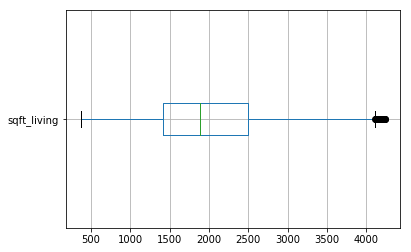

In [123]:
# Look! We still have outliers for price!!
X_train.boxplot(column='sqft_living', vert=False)

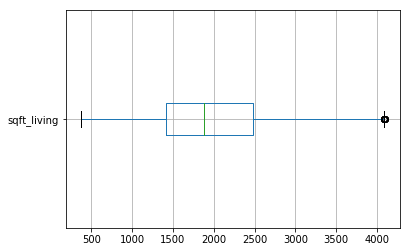

In [124]:
X_train = remove_outliers(X_train, ['sqft_living'])
X_train.boxplot(column='sqft_living', vert=False)

In [125]:
X_train.describe()

,sqft_living,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,bedrooms_33,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_0.0,view_1.0,view_2.0,view_3.0,view_4.0,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5
count,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.0,16339.000000,16339.0,16339.0,16339.0,16339.0,16339.000000,16339.0,16339.0,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.0,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000,16339.000000
mean,1988.797601,0.000122,0.003489,0.184773,0.000367,0.069160,0.146582,0.092478,0.096824,0.252341,0.055756,0.034274,0.022951,0.028827,0.005141,0.003366,0.000918,0.002081,0.000184,0.000122,0.000122,0.0,0.000061,0.0,0.0,0.0,0.0,0.000061,0.0,0.0,0.009180,0.130669,0.470837,0.311096,0.065855,0.010099,0.001285,0.000428,0.000306,0.000122,0.000061,0.000061,0.000061,0.001285,0.011445,0.098721,0.427688,0.289369,0.119530,0.043393,0.008018,0.000490,0.0,0.911684,0.014444,0.041312,0.020687,0.011873,0.507314,0.091070,0.366546,0.006120,0.028766,0.000184
std,755.684859,0.011063,0.058963,0.388125,0.019160,0.253733,0.353699,0.289709,0.295726,0.434369,0.229457,0.181937,0.149753,0.167324,0.071519,0.057923,0.030286,0.045571,0.013549,0.011063,0.011063,0.0,0.007823,0.0,0.0,0.0,0.0,0.007823,0.0,0.0,0.095377,0.337048,0.499164,0.462956,0.248036,0.099986,0.035829,0.020695,0.017491,0.011063,0.007823,0.007823,0.007823,0.035829,0.106371,0.298296,0.494759,0.453483,0.324421,0.203747,0.089184,0.022123,0.0,0.283763,0.119316,0.199017,0.142338,0.108320,0.499962,0.287718,0.481876,0.077995,0.167152,0.013549
min,370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1880.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,

# Finale

And finally we can take our fully cleaned data and pickle it for futher analysis.

In [126]:
pickled_KC= pd.to_pickle(kcdf, './data/cleaned_KC.pkl')

In [127]:
trained_pickle= pd.to_pickle(X_train.join(y_train), './data/trained_pickle.pkl')

In [128]:
tested_pickle= pd.to_pickle(X_test.join(y_test), './data/tested_pickle.pkl')

In [129]:
cleaned_KC = pd.read_pickle('./data/cleaned_KC.pkl')

In [130]:
trained_df = pd.read_pickle('./data/trained_pickle.pkl')
trained_df.head()

,sqft_living,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,bedrooms_1,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,bedrooms_33,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_0.0,view_1.0,view_2.0,view_3.0,view_4.0,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,price
0,1360,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,221900.0
1,3720,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,538000.0
2,1620,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,NaN
3,2010,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,604000.0
4,1170,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,510000.0
